# Model Explanations Using LIME

In order to understand *how* our models are classifying the xray images, we can use LIME to visualize what groups of pixels (aka 'superpixels') are most positively affecting the models decision. If you are running this notebook in a local environment, ensure the following are installed: 

- conda install -c anaconda scikit-image
- conda install -c conda-forge lime
- conda install -c conda-forge ipywidgets

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

## Load Model
#### *Note: In order to use the explainer, images must be trained in color, with image size of 299x299.*
- If keras.models.save_model() was used to save your model

In [4]:
loaded_model = models.load_model(
    '', # path to saved model
    custom_objects=None,
    compile=True # model has already been compiled so set this to True
)

loaded_model

- If model.save() was used to save your model

In [3]:
loaded_model = models.load_model('')

## Identify Image Paths

We create paths for the images in our directory of interest in order to efficiently preprocess our xrays for LIME explanation. These paths also come in handy for comparing predictions to the image labels and identifying which images the model classified incorrectly. 

In [57]:
train_dir = '../data/chest_xray/train_2'
validation_dir = '../data/chest_xray/val'
test_dir = '../data/chest_xray/test'

In [63]:
def get_paths(directory):
    pneu_list = os.listdir(directory + '/PNEUMONIA')
    norm_list = os.listdir(directory + '/NORMAL')

    pneu_labels = [1 for img in pneu_list]
    norm_labels = [0 for img in norm_list]
    
    labels = pneu_labels + norm_labels

    pneu_path = [test_dir + '/PNEUMONIA/'+ img_id for img_id in pneu_list]
    norm_path = [test_dir + '/NORMAL/'+ img_id for img_id in norm_list]
    path_list = pneu_path + norm_path
    
    directory_df = pd.DataFrame(path_list, columns=['image_path'])
    directory_df['image_label']=labels

    return path_list, labels, directory_df

In [64]:
test_path_list, test_labels, test_df = get_paths(test_dir)

## Preprocess Images
- Load in images using their paths
- Set image size as 299 x 299 
- Ensure shape of (299, 299, 3)
- Rescale images by 1/255

In [65]:
def preprocess_image(path_list):
    output = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0) # rescale should match what was used for model training
        output.append(x)
    return np.vstack(output)

In [66]:
images = preprocess_image(test_path_list)
images[0].shape

(299, 299, 3)

## Get LIME Explanation

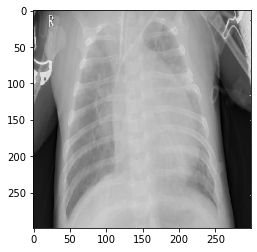

In [72]:
# Choose an image for explanation
xray = images[15]
plt.imshow(xray);

In [73]:
# Instantiate the LimeImageExplainer()
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. Alternatively, 
# if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(xray, 
                                         loaded_model.predict, 
                                         top_labels=5, 
                                         hide_color=None, 
                                         num_samples=1000)

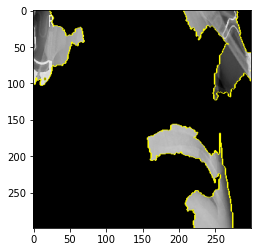

In [74]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

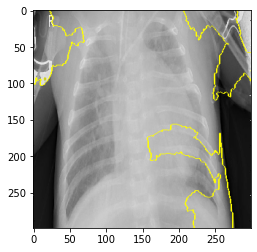

In [75]:
# Include the rest of the image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

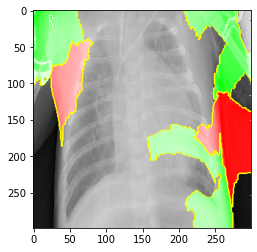

In [78]:
# View the pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

## Heatmap

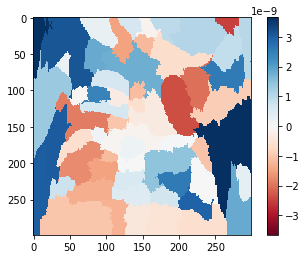

In [27]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();